In [1]:
import gluonnlp as nlp
from torch.utils.data import Dataset
import numpy as np
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense,Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from transformers import ElectraModel, ElectraTokenizer

model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")


Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['electra.embeddings.position_ids']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
dataset_train = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/prepared_train.txt', sep='\t')
dataset_test = pd.read_csv('/Users/waterpurifier/TextClassification_CNN/prepared_test.txt', sep='\t')

class ElectraDataset():
    def __init__(self, dataset_sentence, dataset_label, max_len):
        self.sentences = []
        for i in dataset_sentence:
            temp = []
            tokenid = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(i))
            #tokenidToint = [int(i) for i in tokenid]
            temp.append(tokenid)
            temp = pad_sequences(temp, maxlen = max_len)
            temp = [int(i) for i in temp[0]]
            self.sentences.append(temp)
            
        self.labels = [i for i in dataset_label]
        
        
max_len = 50
vocab_size = 35000 # KoElectra-Base-v3 vocab size : 35000

data_train = ElectraDataset(dataset_train['comment'], dataset_train['label'], max_len)
data_test = ElectraDataset(dataset_test['comment'], dataset_test['label'], max_len)

embedding_dim = 64
dropout_prob = (0.5, 0.8)
num_filters = 32

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                  kernel_size = sz,
                  padding = "valid",
                  activation = "relu", 
                  strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z) # , activation="softmax"
model = Model(model_input, model_output)

In [120]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/Users/waterpurifier/CNN2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_CNN = model.fit(data_train.sentences, data_train.labels, batch_size = 64, epochs=10, validation_data = (data_test.sentences, data_test.labels), verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 00001: val_acc improved from -inf to 0.90217, saving model to /Users/waterpurifier/CNN2.h5
439/439 - 12s - loss: 0.4620 - acc: 0.7929 - val_loss: 0.2826 - val_acc: 0.9022
Epoch 2/10

Epoch 00002: val_acc improved from 0.90217 to 0.91315, saving model to /Users/waterpurifier/CNN2.h5
439/439 - 11s - loss: 0.2708 - acc: 0.9022 - val_loss: 0.2454 - val_acc: 0.9131
Epoch 3/10

Epoch 00003: val_acc improved from 0.91315 to 0.91700, saving model to /Users/waterpurifier/CNN2.h5
439/439 - 11s - loss: 0.2350 - acc: 0.9150 - val_loss: 0.2444 - val_acc: 0.9170
Epoch 4/10

Epoch 00004: val_acc did not improve from 0.91700
439/439 - 11s - loss: 0.2093 - acc: 0.9253 - val_loss: 0.2378 - val_acc: 0.9159
Epoch 5/10

Epoch 00005: val_acc improved from 0.91700 to 0.91771, saving model to /Users/waterpurifier/CNN2.h5
439/439 - 11s - loss: 0.1933 - acc: 0.9308 - val_loss: 0.2436 - val_acc: 0.9177
Epoch 6/10

Epoch 00006: val_acc did not improve from 0.91771
439/439 - 11s - loss: 0.1820 - 

In [121]:
model.save('/Users/waterpurifier/CNN2.h5')
loaded_model_CNN = load_model('/Users/waterpurifier/CNN2.h5')
print('\n 테스트 정확도 : %.4f' %(loaded_model_CNN.evaluate(data_test.sentences, data_test.labels)[1]))

220/220 [==============================] - 0s 1ms/step - loss: 0.2464 - acc: 0.9141

 테스트 정확도 : 0.9141


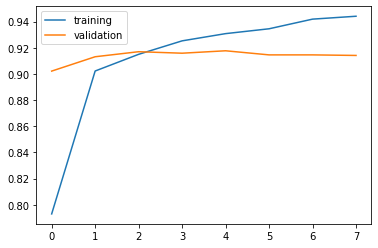

In [122]:
#CNN
import matplotlib.pyplot as plt
plt.plot(history_CNN.history['acc'])
plt.plot(history_CNN.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [221]:
import re
import sys
import os
from soynlp.normalizer import repeat_normalize


class ModelToSentence:
    def __init__(self, new_sentence):
        preparedSentence = re.sub('[^ ^0-9ㄱ-ㅣ가-힣]+','', new_sentence)
        preparedSentence = [repeat_normalize(new_sentence, num_repeats = 2)]
        self.Data = ElectraDataset(preparedSentence, [1], 50)
        self.sentenceToken = tokenizer.tokenize(preparedSentence[0])
        
    def getSentence(self):
        return self.Data
    
    def getTokenizer(self):
        return self.sentenceToken
    
    def getVector(self):
        return self.Data.sentences
    
    def stshow(self):
        count = 0
        Sentence_struct = np.zeros([max_len, max_len])
        for i in range(len(self.Data.sentences[0])):
            value = (35000-self.Data.sentences[0][i])/ 35000 * 100
            Sentence_struct[i][i] = value
            
        plt.rcParams['figure.figsize'] = (12, 6)
        # 20개만 짤랐음
        plt.xlim(0,50)
        plt.imshow(Sentence_struct)
    
    def sentiment_predict(self):
        score = float(loaded_model_CNN.predict(self.Data.sentences))
        if(score > 0.5):
            print("CNN : {:.2f}% 확률로 부정적 댓글입니다.\n".format(score * 100))
            return format(score * 100* (-1))
        else:
            print("CNN : {:.2f}% 확률로 일반적 댓글입니다.\n".format((1 - score) * 100))
            return format((1-score)*100)
    

Tokenizer Result :  ['왜', '이러', '##실', '##까요', '.', '.', 'ㅠㅠ'] 

Vetor Result     :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3178, 6522, 4161, 10397, 18, 18, 8617]] 

CNN : 98.14% 확률로 일반적 댓글입니다.

Model Predict    :  98.13847541809082
----------------------------VecToImg----------------------------
Tokenizer Result :  ['쟤', '##는', '시작', '##한', '##지', '4', '##년', '##이나', '지났', '##는데', '아직', '##도', '상승', '##기', '##가', '없', '##어', '##ㅋㅋ', '고점', '##이', '없', '##어', '##서', '나락', '##은', '안', '##겪', '##어', '##서', '뒤져', '##라', 'ㅋ', '##발', '##ㅋ', '##시', '##ㅋㅋ', '##발'] 

Vetor Result     :  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3277, 4034, 6273, 4283, 4200, 24, 4556, 17482, 11951, 18781, 6545, 4086, 6738, 4031, 4070, 3123, 4025, 16780, 23985, 4007, 3123, 4025, 4129, 27656, 4112, 3081, 5816, 4025, 4129, 22229, 4118, 287, 4387, 4560, 4114, 16780, 4387]] 

CNN : 68.24% 확률로 부정적 댓글입니다.

Model Predict    :  -68

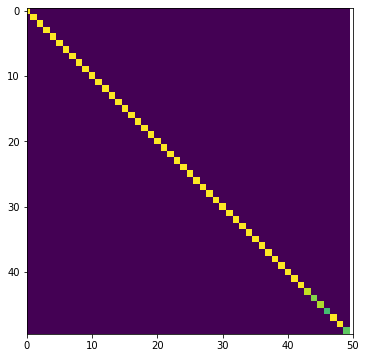

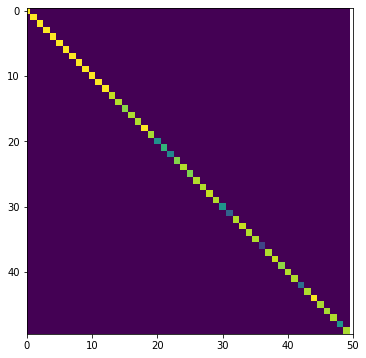

In [222]:
TempText = ModelToSentence('왜 이러실까요.. ㅠㅠㅠㅠㅠㅠ')
print(TempText.getSentence())
print("Tokenizer Result : " , TempText.getTokenizer() , "\n")
print("Vetor Result     : ", TempText.getVector(), "\n") # 1 -> PADDING
print("Model Predict    : ", TempText.sentiment_predict())
print("----------------------------VecToImg----------------------------")
plt.figure(1)
TempText.stshow()

TempText = ModelToSentence('쟤는 시작한지 4년이나 지났는데 아직도 상승기가 없어ㅋㅋ 고점이 없어서 나락은 안겪어서 뒤져라')
print(TempText.getSentence())
print("Tokenizer Result : " , TempText.getTokenizer() , "\n")
print("Vetor Result     : ", TempText.getVector(), "\n") # 1 -> PADDING
print("Model Predict    : ", TempText.sentiment_predict())
print("----------------------------VecToImg----------------------------")
plt.figure(2)
TempText.stshow()


